# MONK with NN

In [15]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

def readFile(name):
    """Import data from csv file"""
    df = pd.read_csv(name, delim_whitespace=True, header=None,
                     names=['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'name'],
                     usecols=['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6'])
    return df

# Get data
monk1_train = readFile('https://archive.ics.uci.edu/ml/machine-learning-databases/monks-problems/monks-1.train')
monk1_test = readFile('https://archive.ics.uci.edu/ml/machine-learning-databases/monks-problems/monks-1.test')

monk1_train.head()

,class,a1,a2,a3,a4,a5,a6
0,1,1,1,1,1,3,1
1,1,1,1,1,1,3,2
2,1,1,1,1,3,2,1
3,1,1,1,1,3,3,2
4,1,1,1,2,1,2,1


### Prepare and preprocess data

In [16]:
# Split into attribute and target
X_train = monk1_train[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']]
y_train = monk1_train['class']
X_test = monk1_test[['a1', 'a2', 'a3', 'a4', 'a5', 'a6']]
y_test = monk1_test['class']

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### Run GridSearchCV to find best parameters

In [17]:
clf = MLPClassifier(early_stopping=True)
clf.fit(X_train, y_train)
# KFold
seed = 42
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

param_grid = {'activation': ['logistic'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': [0.0001, 0.01, 1],
              'learning_rate': ['constant'],
              'max_iter': [100],
              'hidden_layer_sizes': [(50,)]}

grid_search = GridSearchCV(clf, param_grid, cv=kfold)
grid_search.fit(X_train, y_train)
non_nested_score = grid_search.best_score_
print(grid_search.best_estimator_, '\n Score:', non_nested_score)

clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
#print(clf.loss_curve_)

MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 
 Score: 1.0


MLPClassifier(activation='logistic', alpha=0.01, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

### Cross-Validation on training and validation set

In [18]:
def plot_curve(estimator, X, y, cv=None, n_jobs=None,
               train_sizes=np.linspace(.1, 1.0, 5)):
  plt.figure()
  plt.title('Learning curve')
  plt.xlabel("Training examples")
  plt.ylabel("Score")
  train_sizes, train_scores, test_scores = learning_curve(
      estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.grid()

  plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.1,
                   color="r")
  plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.1, color="g")
  plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
           label="Training score")
  plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
           label="Cross-validation score")

  plt.legend(loc="best")
  return plt

{'fit_time': array([0.05940795, 0.06944156, 0.05960059]), 'score_time': array([0.00542879, 0.00477171, 0.00469089]), 'train_f1': array([1., 1., 1.]), 'test_balanced_accuracy': array([1.        , 0.58333333, 1.        ]), 'test_f1': array([1.        , 0.54545455, 1.        ]), 'test_average_precision': array([1.        , 0.71347221, 1.        ]), 'train_roc_auc': array([1., 1., 1.]), 'train_average_precision': array([1., 1., 1.]), 'train_balanced_accuracy': array([1., 1., 1.]), 'test_roc_auc': array([1. , 0.5, 1. ]), 'test_accuracy': array([1.        , 0.58333333, 1.        ]), 'train_accuracy': array([1., 1., 1.])}
Accuracy: 0.99 (+/- 0.05)
Accuracy: 1.00 (+/- 0.00)


Text(0, 0.5, 'Score')

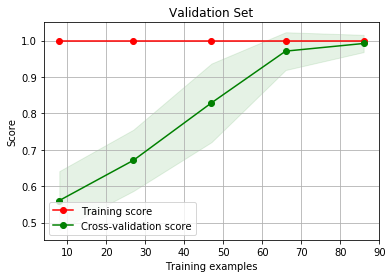

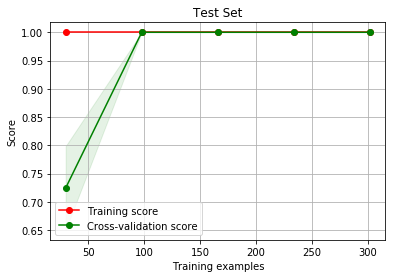

In [22]:
scorings = cross_validate(clf, X_test, y_test, scoring=['accuracy', 'balanced_accuracy', 'average_precision', 'f1', 'roc_auc'])
print(scorings)

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_test, y_test, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

plot_curve(clf, X_train, y_train, cv=cv).plot()
plt.title('Validation Set')
plt.xlabel("Training examples")
plt.ylabel("Score")
plot_curve(clf, X_test, y_test, cv=cv, ).plot()
plt.title('Test Set')
plt.xlabel("Training examples")
plt.ylabel("Score")

### Test on test set

In [20]:
y_pred_test = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

scores = cross_val_score(clf, X, y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NameError: name 'accuracy_score' is not defined